In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

In [2]:
# Get today's date as a datetime64[ns] object
today = pd.to_datetime(datetime.now().date())

In [3]:
# Directory where your Excel files are located
directory = r'C:\Users\IRAXA11\Desktop\Repositories\Expected_recovery_rates\Data'

In [4]:
# -------------------------------- LOAD THE BONDS DATASET -------------------------------- 
# Read data in the Excel file 
bonds = pd.read_excel('ITALY_matured_included.xlsx')

c:\Users\angel\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [8]:
# Drop '#N/A Field Not Applicable' (perpetual bond -- no maturity)
bonds = bonds[bonds['Maturity'] != '#N/A Field Not Applicable']

In [9]:
# Drop '#N/A Field Not Applicable' (perpetual bond -- no maturity)
bonds = bonds[bonds['Issue Date'] != '#N/A Field Not Applicable']

In [10]:
# Make maturity a date
bonds['Maturity'] = pd.to_datetime(bonds['Maturity'], format='%m/%d/%Y')

In [11]:
# Make maturity a date
bonds['Issue Date'] = pd.to_datetime(bonds['Issue Date'], format='%m/%d/%Y')

In [13]:
# Extract year and month from "Issue Date"
bonds['YearMonth'] = bonds['Issue Date'].dt.to_period('M')

In [14]:
# -------------------------------- LOAD THE FX DATASET -------------------------------- 
fx = pd.read_excel('FX_data.xlsx')

In [15]:
fx['Date'] = pd.to_datetime(fx['Date'], format='%m/%d/%Y')

In [16]:
# Extract year and month from "Issue Date"
fx['YearMonth'] = fx['Date'].dt.to_period('M')

In [17]:
fx = fx.drop(['Date'], axis=1)

In [18]:
# Drop anything before 1999
fx = fx[~(fx['YearMonth']<'1999-01')]
bonds = bonds[~(bonds['YearMonth']<'1999-01')]

In [23]:
# -------------------------------- CREATE MAIN DATASET (MERGE) -------------------------------- 
# Merge "bonds" with "FX_data" based on the common column "YearMonth"
df = bonds.merge(fx, on='YearMonth', how='left')
df['USD'] = 1
# -------------------------------- FINISHED MAIN DATASET -------------------------------- 

In [24]:
# Rename columns
df = df.rename(columns={'EURUSD BGN Curncy  (L4)':'EUR', 'GBPUSD BGN Curncy  (R1)':'GBP', 'JPYUSD BGN Curncy  (L1)':'JPY', 
                   'ITLUSD BGN Curncy  (R1)':'ITL', 'CHFUSD BGN Curncy  (R4)':'CHF', 'DEMUSD BGN Curncy  (R3)':'DEM',
                   'NOKUSD BGN Curncy  (L2)':'NOK', 'CZKUSD BGN Curncy  (R2)':'CZK', 'AUDUSD BGN Curncy  (L3)':'AUD',
                   'XEU BGN Curncy  (R1)':'XEU'})

In [25]:
# Identify duplicate rows based on specified columns
duplicate_rows = df.duplicated(subset=['Cpn', 'Maturity', 'Mty Type', 'Currency', 'Gov Law', 'Issue Date'])

# This keeps the first obs. for each duplicate and remove all the others. 

In [31]:
# Invert the boolean mask to get non-duplicate rows
df_temp = df[~duplicate_rows]
# df2 is actually the main dataset...

In [34]:
# Create the function that takes the first two digits of the ISIN and define the market where the bonds are traded 
df2 = df_temp.copy()
df2['Market'] = df_temp['ISIN'].str[:2]

In [35]:
# Function to multiply "Amt Issued" by the corresponding exchange rate
def multiply_by_exchange_rate(row):
    currency_column = row['Currency']
    exchange_rate = row[currency_column]
    amt_issued = row['Amt Issued']
    return amt_issued * exchange_rate

# Duplicate df2
df_test = df2.copy()

# Apply the function to create a new column "Amt Issued (USD)" and "Amt Outstanding"
df_test['Amt Issued'] = df2.apply(multiply_by_exchange_rate, axis=1)
df_test['Amt Outstanding'] = df2.apply(multiply_by_exchange_rate, axis=1)

In [36]:
# check function above
df2[df2['ISIN']=='IT0005580094']['EUR']
df2[df2['ISIN']=='IT0005580094']['Amt Issued']
print(df2[df2['ISIN']=='IT0005580094']['EUR'] * df2[df2['ISIN']=='IT0005580094']['Amt Issued'])
print(df_test[df_test['ISIN']=='IT0005580094']['Amt Issued'])

440    1.176680e+10
dtype: float64
440    1.176680e+10
Name: Amt Issued, dtype: float64


In [44]:
df_temp['Gov Law'].unique()

array(['IT', nan, 'ENGLISH', 'NEW YORK', 'IT NEW YORK'], dtype=object)

### Construct the table in the presentation 

In [37]:
# how many bonds are NA denominated? 
sum(df2['Gov Law'].isna())/len(df2)

0.7089430894308943

In [47]:
sum(df2['Gov Law']=='NEW YORK')/len(df2)

0.026829268292682926

In [38]:
# how many non-matured bonds are IT denominated?
condition1 = (df2['Maturity']>today)
condition2 = (df2['Gov Law']=='IT')

len(df2[condition1 & condition2])/len(df2[condition1])

0.6071428571428571

In [39]:
# how many non-matured bonds are NA denominated?
condition1 = (df2['Maturity']>today)
condition2 = (df2['Gov Law'].isna())

len(df2[condition1 & condition2])/len(df2[condition1])

0.35714285714285715

In [40]:
# how many non-matured bonds are NY denominated?
condition1 = (df2['Maturity']>today)
condition2 = (df2['Gov Law']=='NEW YORK')

len(df2[condition1 & condition2])/len(df2[condition1])

0.03571428571428571

In [41]:
# Check the share of domestic law bonds WITHOUT INPUTATION
# Multiply amount issued and outstanding by the exchange rate at a given point 
df_unknown = df2.copy()
df_unknown['Amt Issued'] = df2.apply(multiply_by_exchange_rate, axis=1)
df_unknown['Amt Outstanding'] = df2.apply(multiply_by_exchange_rate, axis=1)

df_unknown['Gov Law'] = df2['Gov Law'].fillna('Unknown')

grouped_df = df_unknown.groupby(by=['Gov Law'])['Amt Issued'].sum().reset_index()

# Calculate the share of "Amt Issued" for domestic bonds
grouped_df['Percentage'] = grouped_df['Amt Issued'] / (grouped_df['Amt Issued'].sum()) * 100

In [48]:
grouped_df

,Gov Law,Amt Issued,Percentage
0,ENGLISH,2.000000e+09,0.013403
1,IT,5.172995e+12,34.667976
2,IT NEW YORK,2.008153e+09,0.013458
3,NEW YORK,7.019940e+10,0.470457
4,Unknown,9.674334e+12,64.834705


In [49]:
x = df_unknown[df_unknown['Maturity']>today].groupby(by=['Gov Law'])['Amt Issued'].sum().reset_index()
x['Percentage'] = x['Amt Issued'] / (x['Amt Issued'].sum()) * 100

In [50]:
min(df_unknown[df_unknown['Maturity']>today]['Issue Date'])

Timestamp('1999-06-28 00:00:00')

In [51]:
# Input the domestic law bonds for IT market and NA law
df_inputed = df2.copy()

In [52]:
# Input IT law for IT markets...
condition = (df_inputed['Market'] == 'IT') & (df_inputed['Gov Law'].isna())
df_inputed.loc[condition, 'Gov Law'] = 'IT'

In [53]:
# Create a flag for domestic law 
df_inputed['Domestic'] = (df_inputed['Gov Law']=='IT')

### Check for the avg. maturities (inputs for the calibration) 

In [66]:
# Create the column 'Months to Maturity' defined as the difference between the 'Issue Date' and 'Maturity' using the relativedelta function:
df_inputed['Months to Maturity'] = df_inputed.apply(lambda row: relativedelta(row['Maturity'], row['Issue Date']).years*12 +
                                                     relativedelta(row['Maturity'], row['Issue Date']).months, axis=1)

In [67]:
# Simple avg. maturities
print(f'Avg. Maturity for DOMESTIC LAW bonds (in months) is:',  df_inputed[df_inputed['Domestic']==1]['Months to Maturity'].mean(), 'months')
print(f'Avg. Maturity for FOREIGN Law Bonds (in months) is: ', df_inputed[df_inputed['Domestic']!=1]['Months to Maturity'].mean(),  'months')

print(f'Avg. Maturity for DOMESTIC LAW bonds (in years) is:',  df_inputed[df_inputed['Domestic']==1]['Months to Maturity'].mean()/12, 'years')
print(f'Avg. Maturity for FOREIGN Law Bonds (in year) is:  ', df_inputed[df_inputed['Domestic']!=1]['Months to Maturity'].mean()/12,  'years')

Avg. Maturity for DOMESTIC LAW bonds (in months) is: 51.53005927180356 months
Avg. Maturity for FOREIGN Law Bonds (in months) is:  76.95918367346938 months
Avg. Maturity for DOMESTIC LAW bonds (in years) is: 4.29417160598363 years
Avg. Maturity for FOREIGN Law Bonds (in year) is:   6.413265306122448 years


In [68]:
# Simple avg. coupons
print(f'Avg. COUPON for DOMESTIC LAW bonds is:',  df_inputed[df_inputed['Domestic']==1]['Cpn'].mean())
print(f'Avg. COUPON for FOREIGN Law Bonds is: ', df_inputed[df_inputed['Domestic']!=1]['Cpn'].mean())

Avg. COUPON for DOMESTIC LAW bonds is: 1.044801185436071
Avg. COUPON for FOREIGN Law Bonds is:  3.1759097959183675


In [84]:
# Compute those avg. maturities weighting by the amt issued
df_inputed['Weighted Maturity'] =  df_inputed['Months to Maturity'] * df_inputed['Amt Issued']

print(f'Avg. Maturity for DOMESTIC LAW bonds (in months), weighted by the amount issued is:',
       (df_inputed[df_inputed['Domestic']==1]['Weighted Maturity'].sum() / df_inputed[df_inputed['Domestic']==1]['Amt Issued'].sum()), 'months')
print(f'Avg. Maturity for FOREIGN LAW bonds (in months), weighted by the amount issued is:',
       (df_inputed[df_inputed['Domestic']!=1]['Weighted Maturity'].sum() / df_inputed[df_inputed['Domestic']!=1]['Amt Issued'].sum()), 'months')

print(f'Avg. Maturity for DOMESTIC LAW bonds (in years), weighted by the amount issued is:',
       (df_inputed[df_inputed['Domestic']==1]['Weighted Maturity'].sum() / df_inputed[df_inputed['Domestic']==1]['Amt Issued'].sum())/12, 'years')
print(f'Avg. Maturity for FOREIGN LAW bonds (in years), weighted by the amount issued is:',
       (df_inputed[df_inputed['Domestic']!=1]['Weighted Maturity'].sum() / df_inputed[df_inputed['Domestic']!=1]['Amt Issued'].sum())/12, 'years')

Avg. Maturity for DOMESTIC LAW bonds (in months), weighted by the amount issued is: 61.617323858566124 months
Avg. Maturity for FOREIGN LAW bonds (in months), weighted by the amount issued is: 87.01634317654873 months
Avg. Maturity for DOMESTIC LAW bonds (in years), weighted by the amount issued is: 5.134776988213844 years
Avg. Maturity for FOREIGN LAW bonds (in years), weighted by the amount issued is: 7.251361931379061 years


In [86]:
# Compute those avg. maturities weighting by the amt issued
df_inputed['Weighted Coupon'] =  df_inputed['Cpn'] * df_inputed['Amt Issued']

print(f'Avg. COUPON for DOMESTIC LAW bonds, weighted by the amount issued is:',
       (df_inputed[df_inputed['Domestic']==1]['Weighted Coupon'].sum() / df_inputed[df_inputed['Domestic']==1]['Amt Issued'].sum()))
print(f'Avg. COUPON for FOREIGN LAW bonds, weighted by the amount issued is:',
       (df_inputed[df_inputed['Domestic']!=1]['Weighted Coupon'].sum() / df_inputed[df_inputed['Domestic']!=1]['Amt Issued'].sum()))

Avg. COUPON for DOMESTIC LAW bonds, weighted by the amount issued is: 1.4502044273128805
Avg. COUPON for FOREIGN LAW bonds, weighted by the amount issued is: 3.6471814107998335


In [77]:
(df_inputed[df_inputed['Domestic']!=1]['Weighted Maturity'].sum() / df_inputed[df_inputed['Domestic']!=1]['Amt Issued'].sum())/12

7.251361931379061

### Checking Trebesch's sample... 

In [ ]:
# Calculate the difference between 'Maturity' and 'Issuance Date'
time_difference = df_inputed['Maturity'] - df_inputed['Issue Date']

# Create a condition for bonds with a maturity greater than one year
condition = time_difference > pd.Timedelta(days=365)

In [ ]:
# Check now Trebesch's sample between 2003 and July-2014
condition2 = (df_inputed['YearMonth']>'2003-01') & (df_inputed['YearMonth']<'2014-08')
df_sample = df_inputed[condition & condition2]

In [ ]:
# Multiply amount issued and outstanding by the exchange rate at a given point 
df_sample_plot = df_sample.copy()
df_sample_plot['Amt Issued'] = df_inputed.apply(multiply_by_exchange_rate, axis=1)
df_sample_plot['Amt Outstanding'] = df_inputed.apply(multiply_by_exchange_rate, axis=1)

In [ ]:
grouped_df = df_sample_plot.groupby(by=['Gov Law'])['Amt Issued'].sum().reset_index()

# Calculate the share of "Amt Issued" for domestic bonds
grouped_df['Percentage'] = grouped_df['Amt Issued'] / (grouped_df['Amt Issued'].sum()) * 100

In [ ]:
# Those should be the values in the paper... hard to know if they are acurate although the value for foreign debt in the paper
# seems very low... 
grouped_df

In [ ]:
# Plotting
plt.figure(figsize=(10, 10))

# Extracting data for the pie chart
labels = grouped_df['Gov Law']
sizes = grouped_df['Percentage']

# Plot the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, shadow=True)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percentage of Total Amt Issued for Each Category')

# Show the plot
plt.savefig('Trebesch_sample.png')
plt.show()


### Keep only the non-matured debt 

In [ ]:
df_inputed_nonmatured = df_inputed.copy()
df_inputed_nonmatured['Amt Issued'] = df_inputed.apply(multiply_by_exchange_rate, axis=1)
df_inputed_nonmatured['Amt Outstanding'] = df_inputed.apply(multiply_by_exchange_rate, axis=1)

In [ ]:
# Calculate the difference between 'Maturity' and 'Issuance Date'
time_difference = df_inputed_nonmatured['Maturity'] - df_inputed_nonmatured['Issue Date']

# Create a condition for bonds with a maturity greater than one year
condition = time_difference > pd.Timedelta(days=365)

In [ ]:
df_inputed_nonmatured_plot = df_inputed_nonmatured[(df_inputed['Maturity']>'today') & condition]

In [ ]:
grouped_df = df_inputed_nonmatured.groupby(by=['Gov Law'])['Amt Outstanding'].sum().reset_index()

# Calculate the share of "Amt Issued" for domestic bonds
grouped_df['Percentage'] = grouped_df['Amt Outstanding'] / (grouped_df['Amt Outstanding'].sum()) * 100

In [ ]:
# Those should be the values in the paper... hard to know if they are acurate although the value for foreign debt in the paper
# seems very low... 
grouped_df

### Generate time series 

In [55]:
# Copy inputed dataset to create the TS
df_TS = df_inputed.copy()
df_TS['Amt Issued'] = df_inputed.apply(multiply_by_exchange_rate, axis=1)
df_TS['Amt Outstanding'] = df_inputed.apply(multiply_by_exchange_rate, axis=1)

In [56]:
# Extract year from 'YearMonth'
df_TS['Year'] = df_inputed['YearMonth'].dt.year

In [57]:
# Filter the DataFrame for domestic bonds
domestic_bonds = df_TS[df_TS['Domestic']==1]

In [58]:
# Group by 'Year' and calculate the share of 'Amt Issued' for domestic bonds each year
grouped_data = domestic_bonds.groupby('Year')['Amt Issued'].sum() / df_TS.groupby('Year')['Amt Issued'].sum()

# Group by 'Year' and calculate the total amount of debt issued each year
total_debt_issued = df_TS.groupby('Year')['Amt Issued'].sum()

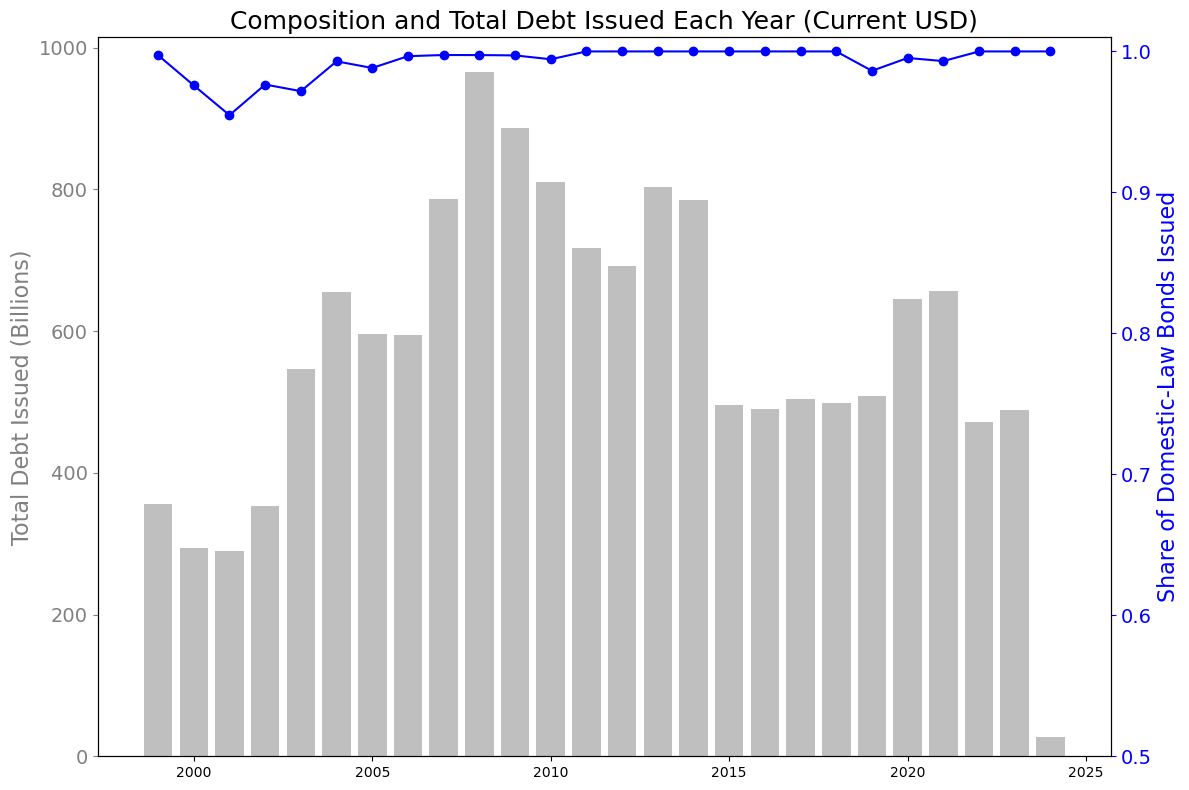

In [61]:
# Create a figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting the total amount of debt issued on the right y-axis
ax1.bar(sorted(df_TS['Year'].unique()), total_debt_issued.values/1e9, color='gray', alpha=0.5, label='Total Debt Issued')
ax1.set_ylabel('Total Debt Issued (Billions)', color='gray', fontsize=16)  # Adjust the fontsize as needed
ax1.tick_params('y', colors='gray', labelsize=14)  # Adjust the fontsize as needed for tick labels

# Create a second y-axis on the right for the bar plot
ax2 = ax1.twinx()
ax2.set_ylim(0.5, 1.01)  # Adjust the range as needed

# Plotting the composition on the left y-axis
ax2.plot(sorted(df_TS['Year'].unique()), grouped_data.values, marker='o', linestyle='-', color='b', label='Composition')
ax2.set_xlabel('Year', fontsize=16)  # Adjust the fontsize as needed
ax2.set_ylabel('Share of Domestic-Law Bonds Issued', color='b', fontsize=16)  # Adjust the fontsize as needed
ax2.tick_params('y', colors='b', labelsize=14)  # Adjust the fontsize as needed for tick labels
# Increase the fontsize for x-axis tick labels
#ax2.tick_params('x', labelsize=14)

# Title and legend
plt.title('Composition and Total Debt Issued Each Year (Current USD)', fontsize=18)  # Adjust the fontsize as needed
fig.tight_layout()

# Show the plot
plt.savefig('ts_bar_plot.png')
plt.show()

### Generate time series for non-inputed dataset 

In [ ]:
# Copy inputed dataset to create the TS
df_TS2 = df2.copy()
df_TS2['Amt Issued'] = df2.apply(multiply_by_exchange_rate, axis=1)
df_TS2['Amt Outstanding'] = df2.apply(multiply_by_exchange_rate, axis=1)

In [ ]:
# Extract year from 'YearMonth'
df_TS2['Year'] = df2['YearMonth'].dt.year

In [ ]:
it_bonds = df_TS2[df_TS2['Gov Law']=='IT']
df_TS2['Gov Law'] = df2['Gov Law'].fillna('Unknown')
na_bonds = df_TS2[df_TS2['Gov Law']=='Unknown']

In [ ]:
# Group by 'Year' and calculate the share of 'Amt Issued' for domestic bonds each year
it_share = it_bonds.groupby('Year')['Amt Issued'].sum() / df_TS2.groupby('Year')['Amt Issued'].sum()
na_share = na_bonds.groupby('Year')['Amt Issued'].sum() / df_TS2.groupby('Year')['Amt Issued'].sum()

In [ ]:
# Plotting the time series
plt.figure(figsize=(12, 8))
it_share.plot(marker='o', linestyle='--', color='blue')
na_share.plot(marker='s', linestyle='-', color='gray')
plt.xlabel('Year')
plt.ylabel('Share of Amt Issued for Domestic Bonds')
plt.title('Time Series of Share of Amt Issued for Domestic Bonds Each Year')
plt.legend(['IT', 'Unknown'])
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.savefig('composition_TS.png')
plt.show()